# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

     -------------------------------------- 455.9/455.9 MB 2.6 MB/s eta 0:00:00


In [2]:
!pip list

Package                      Version
---------------------------- --------------------
absl-py                      1.3.0
altair                       4.2.0
analytics-python             1.4.0
anyio                        3.6.1
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asgiref                      3.5.2
asttokens                    2.0.5
astunparse                   1.6.3
attrs                        21.4.0
azure-core                   1.24.1
azure-cosmos                 4.3.0
Babel                        2.10.1
backcall                     0.2.0
backoff                      1.10.0
beautifulsoup4               4.11.1
bleach                       5.0.0
blinker                      1.4
build                        0.8.0
cachetools                   5.1.0
certifi                      2021.10.8
cffi                         1.15.0
chardet                      4.0.0
charset-normalizer           2.0.12
check-manifest               0.48
click                       

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 4 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

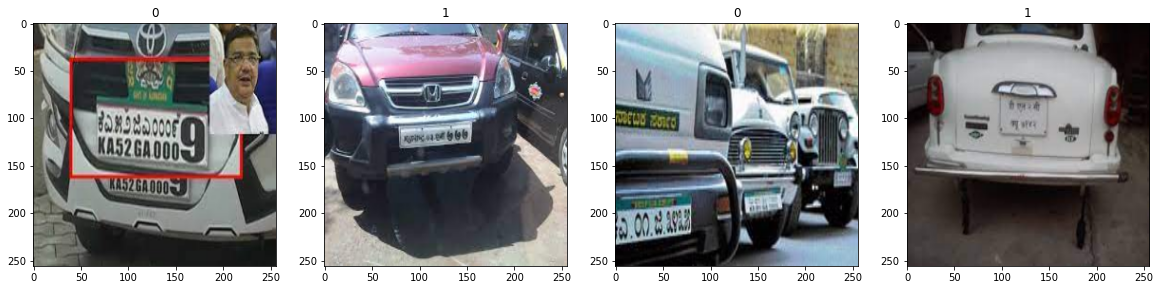

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.2578125 , 0.2578125 , 0.22643995],
          [0.21844363, 0.21844363, 0.18707108],
          [0.25306374, 0.25306374, 0.22169118],
          ...,
          [0.29852942, 0.30637255, 0.35827205],
          [0.3314032 , 0.33924633, 0.38658088],
          [0.29886642, 0.30670956, 0.35376838]],
 
         [[0.24837622, 0.24837622, 0.21700367],
          [0.20884149, 0.20884149, 0.17746893],
          [0.24154484, 0.24154484, 0.21017228],
          ...,
          [0.31600127, 0.31967917, 0.36894315],
          [0.31923923, 0.32236424, 0.36514652],
          [0.28010446, 0.28322944, 0.32557014]],
 
         [[0.23814315, 0.23814315, 0.2067706 ],
          [0.19730464, 0.19730464, 0.16593209],
          [0.22980885, 0.22980885, 0.1984363 ],
          ...,
          [0.32128498, 0.32073233, 0.3631355 ],
          [0.2872635 , 0.28594613, 0.32044366],
          [0.24522011, 0.24390271, 0.27784878]],
 
         ...,
 
         [[0.25548407, 0.26724878, 0.22411151],
          [0.45003

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

0

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [30]:
logdir='logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.